# Wdbc

Completed B=1 for wdbc.data.txt, AUC=0.8826
Completed B=2 for wdbc.data.txt, AUC=0.9452
Completed B=3 for wdbc.data.txt, AUC=0.9530
Completed B=4 for wdbc.data.txt, AUC=0.9560
Completed B=5 for wdbc.data.txt, AUC=0.9731
Completed B=6 for wdbc.data.txt, AUC=0.9612
Completed B=7 for wdbc.data.txt, AUC=0.9592
Completed B=8 for wdbc.data.txt, AUC=0.9612
Completed B=9 for wdbc.data.txt, AUC=0.9637
Completed B=10 for wdbc.data.txt, AUC=0.9624
Completed B=11 for wdbc.data.txt, AUC=0.9624
Completed B=12 for wdbc.data.txt, AUC=0.9624
Completed B=13 for wdbc.data.txt, AUC=0.9624
Completed B=14 for wdbc.data.txt, AUC=0.9624
Completed B=15 for wdbc.data.txt, AUC=0.9624
Completed B=16 for wdbc.data.txt, AUC=0.9624
Completed B=17 for wdbc.data.txt, AUC=0.9624
Completed B=18 for wdbc.data.txt, AUC=0.9624
Completed B=19 for wdbc.data.txt, AUC=0.9624
Completed B=20 for wdbc.data.txt, AUC=0.9624
Completed B=21 for wdbc.data.txt, AUC=0.9624
Completed B=22 for wdbc.data.txt, AUC=0.9624
Completed B=23 for 

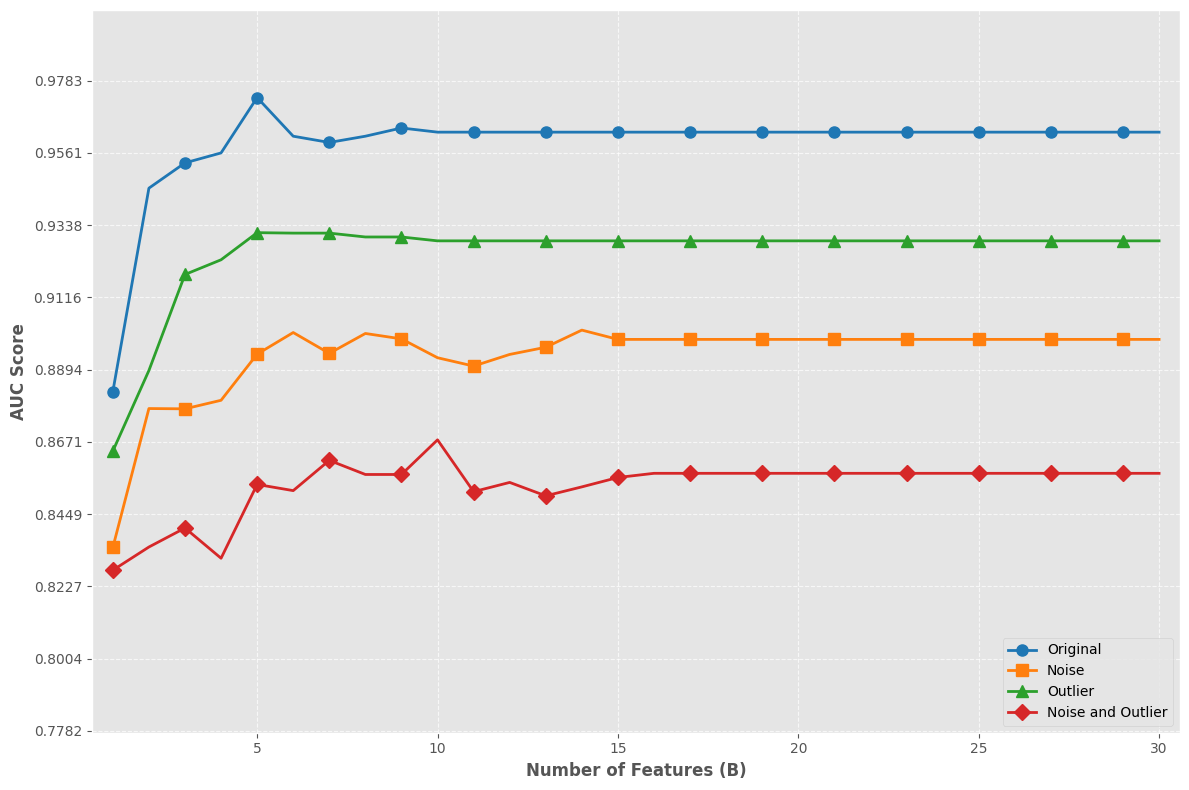

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from docplex.mp.model import Model
import warnings
warnings.filterwarnings("ignore")

def calculate_auc_for_features(file_name, C, tau):
    """Tính AUC cho mỗi giá trị B của một dataset"""
    # Đọc và chuẩn bị dữ liệu
    df = pd.read_csv(file_name, header= None)

    # Tách dữ liệu và nhãn
    X = df.iloc[:, 2:].values
    y = df.iloc[:, 1].values

    # Chuyển đổi nhãn từ B/M thành -1/1
    y = np.where(y == 'M', 1, -1)

    
    n_features = X.shape[1]
    B_values = range(1, n_features + 1)
    auc_scores = []
    
    for B in B_values:
        kf = KFold(n_splits=10, shuffle=True, random_state=42)
        fold_aucs = []
        
        for train_index, val_index in kf.split(X):
            # Chia dữ liệu train/validation
            X_train, X_val = X[train_index], X[val_index]
            y_train, y_val = y[train_index], y[val_index]
            
            # Chuẩn hóa dữ liệu
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_val = scaler.transform(X_val)
            
            # Tạo và giải quyết mô hình
            opt_mod = Model(name='Pin-FS-SVM')
            m, n = X_train.shape
            
            # Định nghĩa các biến
            w = opt_mod.continuous_var_list(n, name='w')
            b = opt_mod.continuous_var(name='b')
            v = opt_mod.binary_var_list(n, name='v')
            xi = opt_mod.continuous_var_list(m, lb=0, name='xi')
            z = opt_mod.continuous_var_list(n, lb=0, name='z')
            
            # Hàm mục tiêu
            opt_mod.minimize(opt_mod.sum(z[j] for j in range(n)) + C * opt_mod.sum(xi[i] for i in range(m)))
            
            # Các ràng buộc
            l = [-2] * n
            u = [2] * n
            
            for i in range(m):
                opt_mod.add_constraint(
                    y_train[i] * (opt_mod.sum(w[j] * X_train[i, j] for j in range(n)) + b) >= 1 - xi[i]
                )
                opt_mod.add_constraint(
                    y_train[i] * (opt_mod.sum(w[j] * X_train[i, j] for j in range(n)) + b) <= 1 + xi[i] * (1/tau)
                )
            
            opt_mod.add_constraint(opt_mod.sum(v[j] for j in range(n)) <= B)
            
            for j in range(n):
                opt_mod.add_constraint(w[j] <= v[j] * u[j])
                opt_mod.add_constraint(w[j] >= l[j] * v[j])
                opt_mod.add_constraint(w[j] <= z[j])
                opt_mod.add_constraint(w[j] >= -z[j])
            
            # Giải quyết mô hình
            solution = opt_mod.solve()
            
            if solution:
                w_opt = np.array([solution.get_value(f'w_{j}') for j in range(n)])
                b_opt = solution.get_value('b')
                y_pred = np.sign(np.dot(X_val, w_opt) + b_opt)
                fold_aucs.append(roc_auc_score(y_val, y_pred))
        
        mean_auc = np.mean(fold_aucs)
        auc_scores.append(mean_auc)
        print(f"Completed B={B} for {file_name}, AUC={mean_auc:.4f}")
    
    return list(B_values), auc_scores

# Cấu hình đồ thị
plt.figure(figsize=(12, 8))
plt.style.use('ggplot')

# Danh sách files và tham số
file_names = [
    'wdbc.data.txt',
    'wdbc_noisy_label_feature.txt',
    'wdbc_noisy_label_outlier.txt',
    'wdbc_both_noise_outlier.txt'
]
# Màu sắc và style cho từng dataset
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
markers = ['o', 's', '^', 'D']
labels = ['Original', 'Noise', 'Outlier', 'Noise and Outlier']

# Lưu trữ tất cả giá trị AUC để tính range
all_auc_values = []
tau_values = [0.1,1,0.5,1]
C_values = [0.125, 0.5, 0.125, 4]

# Vẽ đồ thị cho từng dataset
for i, (file_name, C, tau) in enumerate(zip(file_names, C_values, tau_values)):
    B_values, auc_scores = calculate_auc_for_features(file_name, C, tau)
    all_auc_values.extend(auc_scores)
    plt.plot(B_values, auc_scores, 
             color=colors[i], 
             marker=markers[i], 
             label=labels[i],
             linewidth=2,
             markersize=8,
             markevery=2)

# Tính toán range phù hợp cho trục y
min_auc = min(all_auc_values)
max_auc = max(all_auc_values)
# Điều chỉnh range để tập trung vào khoảng có ý nghĩa
y_min = max(0.5, min_auc - 0.05)  # AUC thường không có ý nghĩa dưới 0.5
y_max = min(1.0, max_auc + 0.3)  # AUC không thể vượt quá 1.0

# Thiết lập giới hạn trục y
plt.ylim(y_min, y_max)

# Thêm các đường grid ngang để dễ theo dõi
plt.grid(True, linestyle='--', alpha=0.7)
# Tăng số lượng đường grid ngang
plt.gca().yaxis.set_major_locator(plt.MultipleLocator((y_max - y_min) / 10))

# Tùy chỉnh đồ thị
plt.xlabel('Number of Features (B)', fontsize=12, fontweight='bold')
plt.ylabel('AUC Score', fontsize=12, fontweight='bold')
# plt.title('Wdbc', fontsize=14, fontweight='bold')
plt.legend(fontsize=10, loc='lower right')

# Thêm padding
plt.margins(x=0.02)

# Điều chỉnh layout
plt.tight_layout()

# Lưu đồ thị
plt.savefig('auc_vs_features_adjusted.png', dpi=300, bbox_inches='tight')
plt.show()

# Australia

Completed B=1 for australia.txt, AUC=0.8579
Completed B=2 for australia.txt, AUC=0.8579
Completed B=3 for australia.txt, AUC=0.8579
Completed B=4 for australia.txt, AUC=0.8579
Completed B=5 for australia.txt, AUC=0.8579
Completed B=6 for australia.txt, AUC=0.8579
Completed B=7 for australia.txt, AUC=0.8579
Completed B=8 for australia.txt, AUC=0.8579
Completed B=9 for australia.txt, AUC=0.8579
Completed B=10 for australia.txt, AUC=0.8579
Completed B=11 for australia.txt, AUC=0.8579
Completed B=12 for australia.txt, AUC=0.8579
Completed B=13 for australia.txt, AUC=0.8579
Completed B=14 for australia.txt, AUC=0.8579
Completed B=1 for australia_noise_label_feature.txt, AUC=0.8163
Completed B=2 for australia_noise_label_feature.txt, AUC=0.8163
Completed B=3 for australia_noise_label_feature.txt, AUC=0.8163
Completed B=4 for australia_noise_label_feature.txt, AUC=0.8163
Completed B=5 for australia_noise_label_feature.txt, AUC=0.8163
Completed B=6 for australia_noise_label_feature.txt, AUC=0.

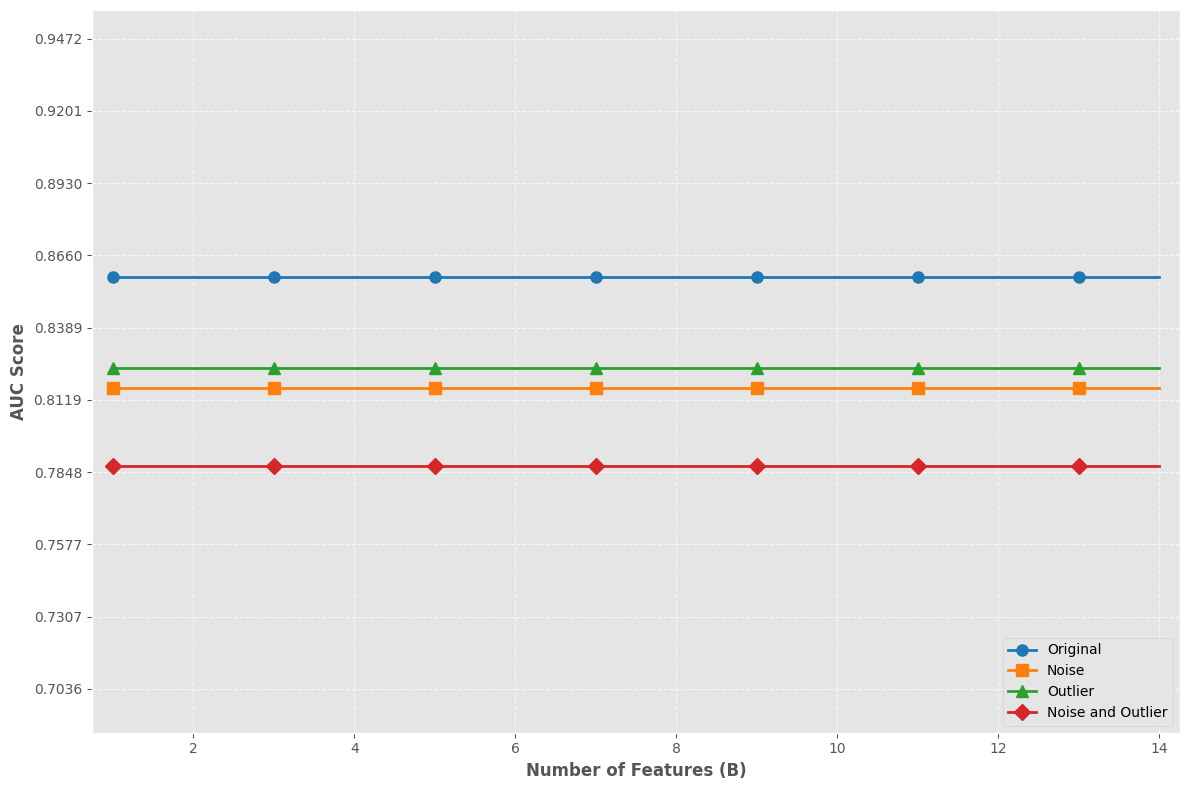

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from docplex.mp.model import Model
import warnings
warnings.filterwarnings("ignore")

def calculate_auc_for_features(file_name, C, tau):
    """Tính AUC cho mỗi giá trị B của một dataset"""
    # Đọc và chuẩn bị dữ liệu
    if file_name == 'australia.txt':
        df = pd.read_csv(file_name, header= None, sep=' ')
    else:
        df = pd.read_csv(file_name, header= None)

    X = df.iloc[:,:14].values
    y = df.iloc[:,14].values
    y = np.where(y == 0, -1, y)

    
    n_features = X.shape[1]
    B_values = range(1, n_features + 1)
    auc_scores = []
    
    for B in B_values:
        kf = KFold(n_splits=10, shuffle=True, random_state=42)
        fold_aucs = []
        
        for train_index, val_index in kf.split(X):
            # Chia dữ liệu train/validation
            X_train, X_val = X[train_index], X[val_index]
            y_train, y_val = y[train_index], y[val_index]
            
            # Chuẩn hóa dữ liệu
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_val = scaler.transform(X_val)
            
            # Tạo và giải quyết mô hình
            opt_mod = Model(name='Pin-FS-SVM')
            m, n = X_train.shape
            
            # Định nghĩa các biến
            w = opt_mod.continuous_var_list(n, name='w')
            b = opt_mod.continuous_var(name='b')
            v = opt_mod.binary_var_list(n, name='v')
            xi = opt_mod.continuous_var_list(m, lb=0, name='xi')
            z = opt_mod.continuous_var_list(n, lb=0, name='z')
            
            # Hàm mục tiêu
            opt_mod.minimize(opt_mod.sum(z[j] for j in range(n)) + C * opt_mod.sum(xi[i] for i in range(m)))
            
            # Các ràng buộc
            l = [-2] * n
            u = [2] * n
            
            for i in range(m):
                opt_mod.add_constraint(
                    y_train[i] * (opt_mod.sum(w[j] * X_train[i, j] for j in range(n)) + b) >= 1 - xi[i]
                )
                opt_mod.add_constraint(
                    y_train[i] * (opt_mod.sum(w[j] * X_train[i, j] for j in range(n)) + b) <= 1 + xi[i] * (1/tau)
                )
            
            opt_mod.add_constraint(opt_mod.sum(v[j] for j in range(n)) <= B)
            
            for j in range(n):
                opt_mod.add_constraint(w[j] <= v[j] * u[j])
                opt_mod.add_constraint(w[j] >= l[j] * v[j])
                opt_mod.add_constraint(w[j] <= z[j])
                opt_mod.add_constraint(w[j] >= -z[j])
            
            # Giải quyết mô hình
            solution = opt_mod.solve()
            
            if solution:
                w_opt = np.array([solution.get_value(f'w_{j}') for j in range(n)])
                b_opt = solution.get_value('b')
                y_pred = np.sign(np.dot(X_val, w_opt) + b_opt)
                fold_aucs.append(roc_auc_score(y_val, y_pred))
        
        mean_auc = np.mean(fold_aucs)
        auc_scores.append(mean_auc)
        print(f"Completed B={B} for {file_name}, AUC={mean_auc:.4f}")
    
    return list(B_values), auc_scores

# Cấu hình đồ thị
plt.figure(figsize=(12, 8))
plt.style.use('ggplot')

# Danh sách files và tham số
file_names = [
    "australia.txt",
    "australia_noise_label_feature.txt",
    "australia_outlier.txt",
    'australia_both_noise_outlier.txt'
]
# Màu sắc và style cho từng dataset
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
markers = ['o', 's', '^', 'D']
labels = ['Original', 'Noise', 'Outlier', 'Noise and Outlier']

# Lưu trữ tất cả giá trị AUC để tính range
all_auc_values = []
tau_values = [0.1,0.1,0.1,0.1]
C_values = [0.125, 0.125, 0.125, 0.125]

# Vẽ đồ thị cho từng dataset
for i, (file_name, C, tau) in enumerate(zip(file_names, C_values, tau_values)):
    B_values, auc_scores = calculate_auc_for_features(file_name, C, tau)
    all_auc_values.extend(auc_scores)
    plt.plot(B_values, auc_scores, 
             color=colors[i], 
             marker=markers[i], 
             label=labels[i],
             linewidth=2,
             markersize=8,
             markevery=2)

# Tính toán range phù hợp cho trục y
min_auc = min(all_auc_values)
max_auc = max(all_auc_values)
# Điều chỉnh range để tập trung vào khoảng có ý nghĩa
y_min = max(0.5, min_auc - 0.1)  # AUC thường không có ý nghĩa dưới 0.5
y_max = min(1.0, max_auc + 0.1)  # AUC không thể vượt quá 1.0

# Thiết lập giới hạn trục y
plt.ylim(y_min, y_max)

# Thêm các đường grid ngang để dễ theo dõi
plt.grid(True, linestyle='--', alpha=0.7)
# Tăng số lượng đường grid ngang
plt.gca().yaxis.set_major_locator(plt.MultipleLocator((y_max - y_min) / 10))

# Tùy chỉnh đồ thị
plt.xlabel('Number of Features (B)', fontsize=12, fontweight='bold')
plt.ylabel('AUC Score', fontsize=12, fontweight='bold')
# plt.title('Australia', fontsize=14, fontweight='bold')
plt.legend(fontsize=10, loc='lower right')

# Thêm padding
plt.margins(x=0.02)

# Điều chỉnh layout
plt.tight_layout()

# Lưu đồ thị
plt.savefig('auc_vs_features_adjusted.png', dpi=300, bbox_inches='tight')
plt.show()

# Cleveland

Completed B=1 for Heart_disease_cleveland_new.csv, AUC=0.7572
Completed B=2 for Heart_disease_cleveland_new.csv, AUC=0.7737
Completed B=3 for Heart_disease_cleveland_new.csv, AUC=0.7868
Completed B=4 for Heart_disease_cleveland_new.csv, AUC=0.8290
Completed B=5 for Heart_disease_cleveland_new.csv, AUC=0.8065
Completed B=6 for Heart_disease_cleveland_new.csv, AUC=0.8423
Completed B=7 for Heart_disease_cleveland_new.csv, AUC=0.8234
Completed B=8 for Heart_disease_cleveland_new.csv, AUC=0.8302
Completed B=9 for Heart_disease_cleveland_new.csv, AUC=0.8303
Completed B=10 for Heart_disease_cleveland_new.csv, AUC=0.8273
Completed B=11 for Heart_disease_cleveland_new.csv, AUC=0.8273
Completed B=12 for Heart_disease_cleveland_new.csv, AUC=0.8273
Completed B=13 for Heart_disease_cleveland_new.csv, AUC=0.8273
Completed B=1 for clevaland_noise_label_feature.csv, AUC=0.7244
Completed B=2 for clevaland_noise_label_feature.csv, AUC=0.7381
Completed B=3 for clevaland_noise_label_feature.csv, AUC=0.759

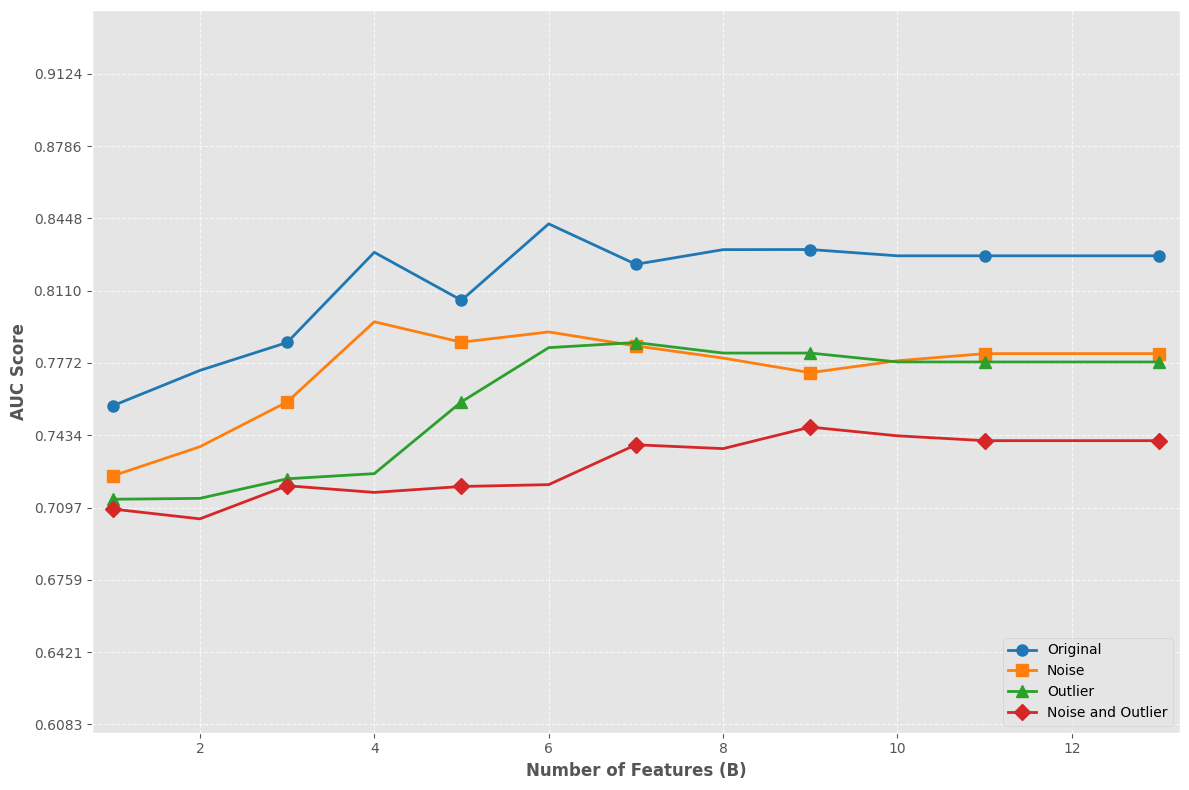

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from docplex.mp.model import Model
import warnings
warnings.filterwarnings("ignore")

def calculate_auc_for_features(file_name, C, tau, random_state):
    """Tính AUC cho mỗi giá trị B của một dataset"""
    # Đọc và chuẩn bị dữ liệu
    df = pd.read_csv(file_name, header= None)

    X = df.iloc[1:,0:13].values
    X = X.astype(float)
    y = df.iloc[1:, 13].values
    y = y.astype(float)
    y = np.where(y == 0 , -1 , y)

    
    n_features = X.shape[1]
    B_values = range(1, n_features + 1)
    auc_scores = []
    
    for B in B_values:
        kf = KFold(n_splits=10, shuffle=True, random_state= random_state)
        fold_aucs = []
        
        for train_index, val_index in kf.split(X):
            # Chia dữ liệu train/validation
            X_train, X_val = X[train_index], X[val_index]
            y_train, y_val = y[train_index], y[val_index]
            
            # Chuẩn hóa dữ liệu
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_val = scaler.transform(X_val)
            
            # Tạo và giải quyết mô hình
            opt_mod = Model(name='Pin-FS-SVM')
            m, n = X_train.shape
            
            # Định nghĩa các biến
            w = opt_mod.continuous_var_list(n, name='w')
            b = opt_mod.continuous_var(name='b')
            v = opt_mod.binary_var_list(n, name='v')
            xi = opt_mod.continuous_var_list(m, lb=0, name='xi')
            z = opt_mod.continuous_var_list(n, lb=0, name='z')
            
            # Hàm mục tiêu
            opt_mod.minimize(opt_mod.sum(z[j] for j in range(n)) + C * opt_mod.sum(xi[i] for i in range(m)))
            
            # Các ràng buộc
            l = [-4] * n
            u = [4] * n
            
            for i in range(m):
                opt_mod.add_constraint(
                    y_train[i] * (opt_mod.sum(w[j] * X_train[i, j] for j in range(n)) + b) >= 1 - xi[i]
                )
                opt_mod.add_constraint(
                    y_train[i] * (opt_mod.sum(w[j] * X_train[i, j] for j in range(n)) + b) <= 1 + xi[i] * (1/tau)
                )
            
            opt_mod.add_constraint(opt_mod.sum(v[j] for j in range(n)) <= B)
            
            for j in range(n):
                opt_mod.add_constraint(w[j] <= v[j] * u[j])
                opt_mod.add_constraint(w[j] >= l[j] * v[j])
                opt_mod.add_constraint(w[j] <= z[j])
                opt_mod.add_constraint(w[j] >= -z[j])
            
            # Giải quyết mô hình
            solution = opt_mod.solve()
            
            if solution:
                w_opt = np.array([solution.get_value(f'w_{j}') for j in range(n)])
                b_opt = solution.get_value('b')
                y_pred = np.sign(np.dot(X_val, w_opt) + b_opt)
                fold_aucs.append(roc_auc_score(y_val, y_pred))
        
        mean_auc = np.mean(fold_aucs)
        auc_scores.append(mean_auc)
        print(f"Completed B={B} for {file_name}, AUC={mean_auc:.4f}")
    
    return list(B_values), auc_scores

# Cấu hình đồ thị
plt.figure(figsize=(12, 8))
plt.style.use('ggplot')

# Danh sách files và tham số
file_names = [
    'Heart_disease_cleveland_new.csv',
    'clevaland_noise_label_feature.csv',
    'clevaland_outlier.csv',
    'cleveland_both_noise_outlier.csv'
]
# Màu sắc và style cho từng dataset
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
markers = ['o', 's', '^', 'D']
labels = ['Original', 'Noise', 'Outlier', 'Noise and Outlier']

# Lưu trữ tất cả giá trị AUC để tính range
all_auc_values = []
tau_values = [0.1,0.1,0.1,0.1]
C_values = [16,2,1,4]

# Vẽ đồ thị cho từng dataset
for i, (file_name, C, tau) in enumerate(zip(file_names, C_values, tau_values)):
    random_state = 1
    B_values, auc_scores = calculate_auc_for_features(file_name, C, tau, random_state=random_state)
    all_auc_values.extend(auc_scores)
    plt.plot(B_values, auc_scores, 
             color=colors[i], 
             marker=markers[i], 
             label=labels[i],
             linewidth=2,
             markersize=8,
             markevery=2)

# Tính toán range phù hợp cho trục y
min_auc = min(all_auc_values)
max_auc = max(all_auc_values)
# Điều chỉnh range để tập trung vào khoảng có ý nghĩa
y_min = max(0.5, min_auc - 0.1)  # AUC thường không có ý nghĩa dưới 0.5
y_max = min(1.0, max_auc + 0.1)  # AUC không thể vượt quá 1.0

# Thiết lập giới hạn trục y
plt.ylim(y_min, y_max)

# Thêm các đường grid ngang để dễ theo dõi
plt.grid(True, linestyle='--', alpha=0.7)
# Tăng số lượng đường grid ngang
plt.gca().yaxis.set_major_locator(plt.MultipleLocator((y_max - y_min) / 10))

# Tùy chỉnh đồ thị
plt.xlabel('Number of Features (B)', fontsize=12, fontweight='bold')
plt.ylabel('AUC Score', fontsize=12, fontweight='bold')
# plt.title('Cleveland', fontsize=14, fontweight='bold')
plt.legend(fontsize=10, loc='lower right')

# Thêm padding
plt.margins(x=0.02)

# Điều chỉnh layout
plt.tight_layout()

# Lưu đồ thị
plt.savefig('auc_vs_features_adjusted.png', dpi=300, bbox_inches='tight')
plt.show()

# Ionosphere

Completed B=1 for ionosphere.data, AUC=0.6391
Completed B=2 for ionosphere.data, AUC=0.8408
Completed B=3 for ionosphere.data, AUC=0.8274
Completed B=4 for ionosphere.data, AUC=0.8445
Completed B=5 for ionosphere.data, AUC=0.8345
Completed B=6 for ionosphere.data, AUC=0.8309
Completed B=7 for ionosphere.data, AUC=0.8396
Completed B=8 for ionosphere.data, AUC=0.8391
Completed B=9 for ionosphere.data, AUC=0.8289
Completed B=10 for ionosphere.data, AUC=0.8477
Completed B=11 for ionosphere.data, AUC=0.8527
Completed B=12 for ionosphere.data, AUC=0.8549
Completed B=13 for ionosphere.data, AUC=0.8436
Completed B=14 for ionosphere.data, AUC=0.8412
Completed B=15 for ionosphere.data, AUC=0.8434
Completed B=16 for ionosphere.data, AUC=0.8434
Completed B=17 for ionosphere.data, AUC=0.8434
Completed B=18 for ionosphere.data, AUC=0.8434
Completed B=19 for ionosphere.data, AUC=0.8434
Completed B=20 for ionosphere.data, AUC=0.8434
Completed B=21 for ionosphere.data, AUC=0.8434
Completed B=22 for ion

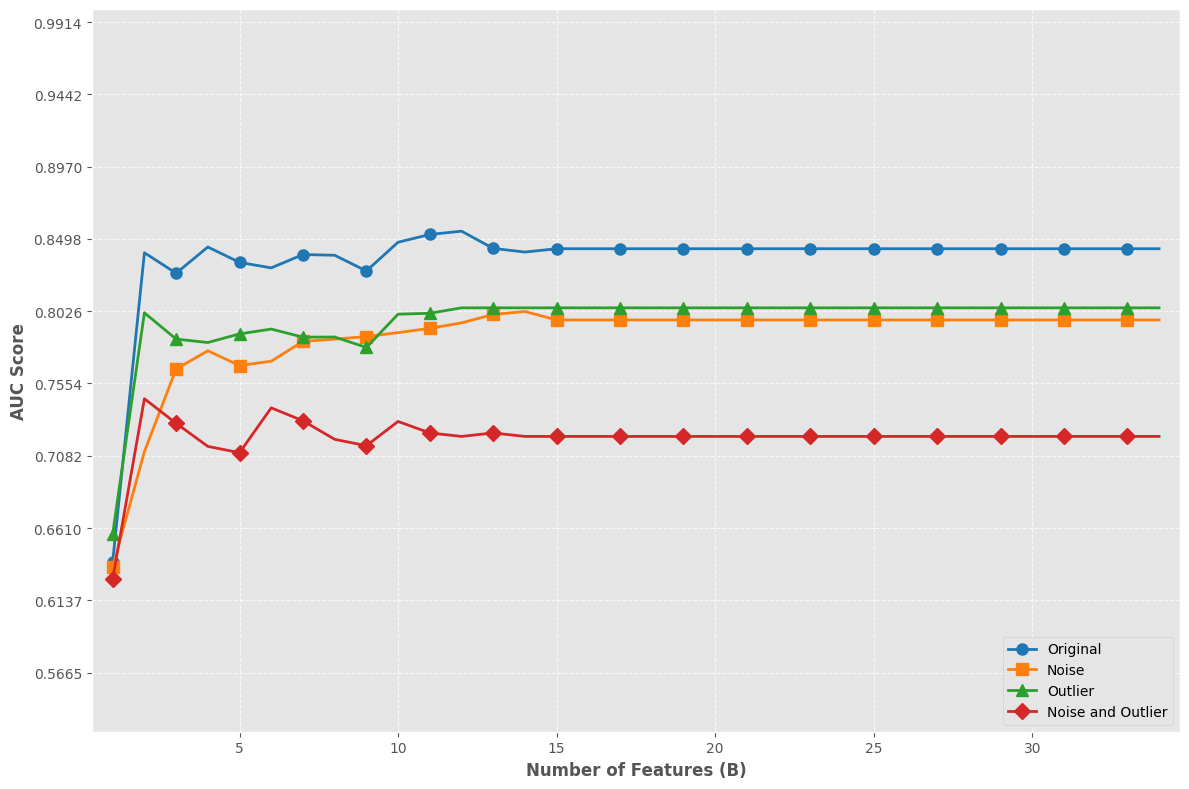

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from docplex.mp.model import Model
import warnings
warnings.filterwarnings("ignore")

def calculate_auc_for_features(file_name, C, tau):
    """Tính AUC cho mỗi giá trị B của một dataset"""
    # Đọc và chuẩn bị dữ liệu
    df = pd.read_csv(file_name, header= None)

    # Tách dữ liệu và nhãn
    X = df.iloc[:, :-1].values
    y = df.iloc[:, -1].values
    # Chuyển đổi nhãn từ B/M thành -1/1
    y = np.where(y == 'g', 1, -1)

    
    n_features = X.shape[1]
    B_values = range(1, n_features + 1)
    auc_scores = []
    
    for B in B_values:
        kf = KFold(n_splits=10, shuffle=True, random_state=42)
        fold_aucs = []
        
        for train_index, val_index in kf.split(X):
            # Chia dữ liệu train/validation
            X_train, X_val = X[train_index], X[val_index]
            y_train, y_val = y[train_index], y[val_index]
            
            # Chuẩn hóa dữ liệu
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_val = scaler.transform(X_val)
            
            # Tạo và giải quyết mô hình
            opt_mod = Model(name='Pin-FS-SVM')
            m, n = X_train.shape
            
            # Định nghĩa các biến
            w = opt_mod.continuous_var_list(n, name='w')
            b = opt_mod.continuous_var(name='b')
            v = opt_mod.binary_var_list(n, name='v')
            xi = opt_mod.continuous_var_list(m, lb=0, name='xi')
            z = opt_mod.continuous_var_list(n, lb=0, name='z')
            
            # Hàm mục tiêu
            opt_mod.minimize(opt_mod.sum(z[j] for j in range(n)) + C * opt_mod.sum(xi[i] for i in range(m)))
            
            # Các ràng buộc
            l = [-2] * n
            u = [2] * n
            
            for i in range(m):
                opt_mod.add_constraint(
                    y_train[i] * (opt_mod.sum(w[j] * X_train[i, j] for j in range(n)) + b) >= 1 - xi[i]
                )
                opt_mod.add_constraint(
                    y_train[i] * (opt_mod.sum(w[j] * X_train[i, j] for j in range(n)) + b) <= 1 + xi[i] * (1/tau)
                )
            
            opt_mod.add_constraint(opt_mod.sum(v[j] for j in range(n)) <= B)
            
            for j in range(n):
                opt_mod.add_constraint(w[j] <= v[j] * u[j])
                opt_mod.add_constraint(w[j] >= l[j] * v[j])
                opt_mod.add_constraint(w[j] <= z[j])
                opt_mod.add_constraint(w[j] >= -z[j])
            
            # Giải quyết mô hình
            solution = opt_mod.solve()
            
            if solution:
                w_opt = np.array([solution.get_value(f'w_{j}') for j in range(n)])
                b_opt = solution.get_value('b')
                y_pred = np.sign(np.dot(X_val, w_opt) + b_opt)
                fold_aucs.append(roc_auc_score(y_val, y_pred))
        
        mean_auc = np.mean(fold_aucs)
        auc_scores.append(mean_auc)
        print(f"Completed B={B} for {file_name}, AUC={mean_auc:.4f}")
    
    return list(B_values), auc_scores

# Cấu hình đồ thị
plt.figure(figsize=(12, 8))
plt.style.use('ggplot')

# Danh sách files và tham số
file_names = [
    'ionosphere.data',
    'ionosphere_noise_label_feature.txt',
    'ionosphere_outlier.txt',
    "ionosphere_both_noise_outlier.txt"
]
# Màu sắc và style cho từng dataset
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
markers = ['o', 's', '^', 'D']
labels = ['Original', 'Noise', 'Outlier', 'Noise and Outlier']

# Lưu trữ tất cả giá trị AUC để tính range
all_auc_values = []
tau_values = [0.1,0.1,0.1,0.1]
C_values = [2,1,2,0.5]

# Vẽ đồ thị cho từng dataset
for i, (file_name, C, tau) in enumerate(zip(file_names, C_values, tau_values)):
    B_values, auc_scores = calculate_auc_for_features(file_name, C, tau)
    all_auc_values.extend(auc_scores)
    plt.plot(B_values, auc_scores, 
             color=colors[i], 
             marker=markers[i], 
             label=labels[i],
             linewidth=2,
             markersize=8,
             markevery=2)

# Tính toán range phù hợp cho trục y
min_auc = min(all_auc_values)
max_auc = max(all_auc_values)
# Điều chỉnh range để tập trung vào khoảng có ý nghĩa
y_min = max(0.5, min_auc - 0.1)  # AUC thường không có ý nghĩa dưới 0.5
y_max = min(1.0, max_auc + 0.2)  # AUC không thể vượt quá 1.0

# Thiết lập giới hạn trục y
plt.ylim(y_min, y_max)

# Thêm các đường grid ngang để dễ theo dõi
plt.grid(True, linestyle='--', alpha=0.7)
# Tăng số lượng đường grid ngang
plt.gca().yaxis.set_major_locator(plt.MultipleLocator((y_max - y_min) / 10))

# Tùy chỉnh đồ thị
plt.xlabel('Number of Features (B)', fontsize=12, fontweight='bold')
plt.ylabel('AUC Score', fontsize=12, fontweight='bold')
# plt.title('Ionosphere', fontsize=14, fontweight='bold')
plt.legend(fontsize=10, loc='lower right')

# Thêm padding
plt.margins(x=0.02)

# Điều chỉnh layout
plt.tight_layout()

# Lưu đồ thị
plt.savefig('auc_vs_features_adjusted.png', dpi=300, bbox_inches='tight')
plt.show()

# Diabetes

Completed B=1 for diabetes.csv, AUC=0.7098
Completed B=2 for diabetes.csv, AUC=0.6992
Completed B=3 for diabetes.csv, AUC=0.7179
Completed B=4 for diabetes.csv, AUC=0.7320
Completed B=5 for diabetes.csv, AUC=0.7469
Completed B=6 for diabetes.csv, AUC=0.7469
Completed B=7 for diabetes.csv, AUC=0.7469
Completed B=8 for diabetes.csv, AUC=0.7469
Completed B=1 for diabetes_noise_label_feature.csv, AUC=0.6970
Completed B=2 for diabetes_noise_label_feature.csv, AUC=0.7068
Completed B=3 for diabetes_noise_label_feature.csv, AUC=0.7350
Completed B=4 for diabetes_noise_label_feature.csv, AUC=0.7254
Completed B=5 for diabetes_noise_label_feature.csv, AUC=0.7382
Completed B=6 for diabetes_noise_label_feature.csv, AUC=0.7361
Completed B=7 for diabetes_noise_label_feature.csv, AUC=0.7361
Completed B=8 for diabetes_noise_label_feature.csv, AUC=0.7361
Completed B=1 for diabetes_outlier.csv, AUC=0.6790
Completed B=2 for diabetes_outlier.csv, AUC=0.6632
Completed B=3 for diabetes_outlier.csv, AUC=0.7074

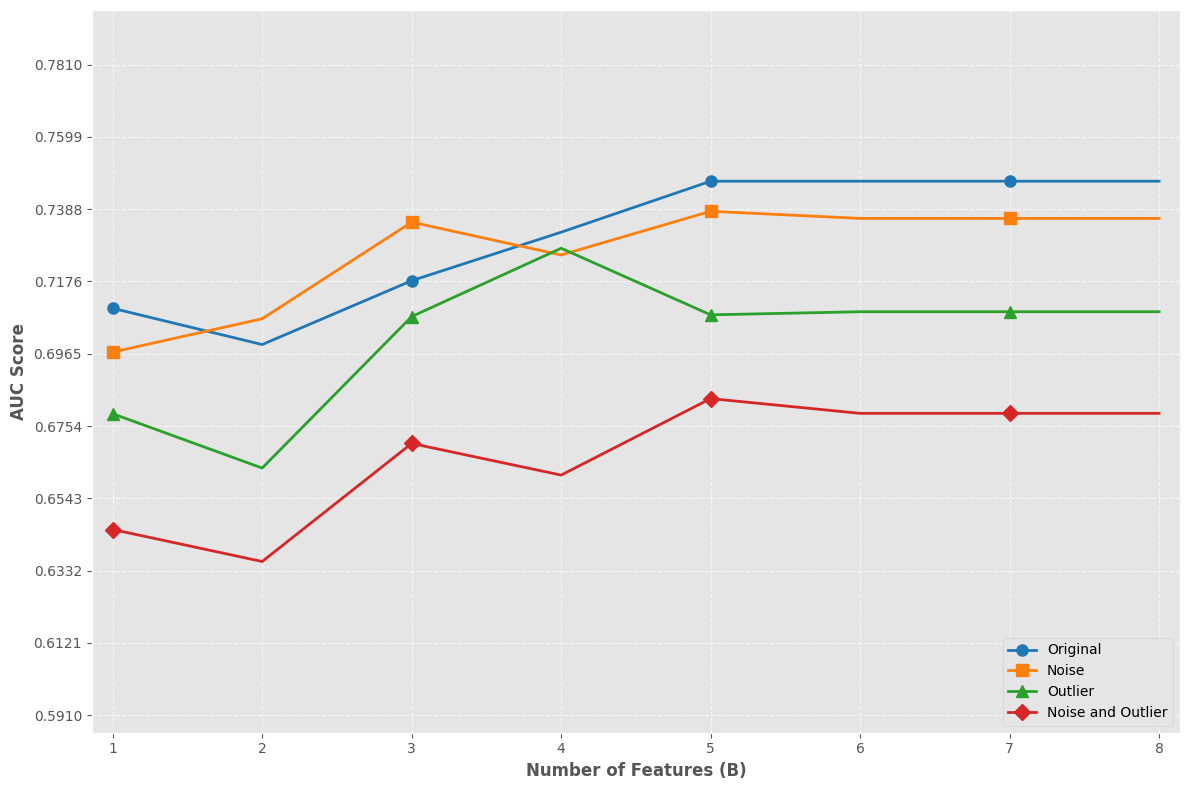

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from docplex.mp.model import Model
import warnings
warnings.filterwarnings("ignore")

def calculate_auc_for_features(file_name, C, tau):
    """Tính AUC cho mỗi giá trị B của một dataset"""
    # Đọc và chuẩn bị dữ liệu
    df = pd.read_csv(file_name)
    X = df.iloc[:, :-1].values
    y = df.iloc[:, -1].values
    y = np.where(y == 0, -1, 1)

    
    n_features = X.shape[1]
    B_values = range(1, n_features + 1)
    auc_scores = []
    
    for B in B_values:
        kf = KFold(n_splits=10, shuffle=True, random_state=42)
        fold_aucs = []
        
        for train_index, val_index in kf.split(X):
            # Chia dữ liệu train/validation
            X_train, X_val = X[train_index], X[val_index]
            y_train, y_val = y[train_index], y[val_index]
            
            # Chuẩn hóa dữ liệu
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_val = scaler.transform(X_val)
            
            # Tạo và giải quyết mô hình
            opt_mod = Model(name='Pin-FS-SVM')
            m, n = X_train.shape
            
            # Định nghĩa các biến
            w = opt_mod.continuous_var_list(n, name='w')
            b = opt_mod.continuous_var(name='b')
            v = opt_mod.binary_var_list(n, name='v')
            xi = opt_mod.continuous_var_list(m, lb=0, name='xi')
            z = opt_mod.continuous_var_list(n, lb=0, name='z')
            
            # Hàm mục tiêu
            opt_mod.minimize(opt_mod.sum(z[j] for j in range(n)) + C * opt_mod.sum(xi[i] for i in range(m)))
            
            # Các ràng buộc
            l = [-2] * n
            u = [2] * n
            
            for i in range(m):
                opt_mod.add_constraint(
                    y_train[i] * (opt_mod.sum(w[j] * X_train[i, j] for j in range(n)) + b) >= 1 - xi[i]
                )
                opt_mod.add_constraint(
                    y_train[i] * (opt_mod.sum(w[j] * X_train[i, j] for j in range(n)) + b) <= 1 + xi[i] * (1/tau)
                )
            
            opt_mod.add_constraint(opt_mod.sum(v[j] for j in range(n)) <= B)
            
            for j in range(n):
                opt_mod.add_constraint(w[j] <= v[j] * u[j])
                opt_mod.add_constraint(w[j] >= l[j] * v[j])
                opt_mod.add_constraint(w[j] <= z[j])
                opt_mod.add_constraint(w[j] >= -z[j])
            
            # Giải quyết mô hình
            solution = opt_mod.solve()
            
            if solution:
                w_opt = np.array([solution.get_value(f'w_{j}') for j in range(n)])
                b_opt = solution.get_value('b')
                y_pred = np.sign(np.dot(X_val, w_opt) + b_opt)
                fold_aucs.append(roc_auc_score(y_val, y_pred))
        
        mean_auc = np.mean(fold_aucs)
        auc_scores.append(mean_auc)
        print(f"Completed B={B} for {file_name}, AUC={mean_auc:.4f}")
    
    return list(B_values), auc_scores

# Cấu hình đồ thị
plt.figure(figsize=(12, 8))
plt.style.use('ggplot')

# Danh sách files và tham số
file_names = [
    'diabetes.csv',
    'diabetes_noise_label_feature.csv',
    'diabetes_outlier.csv',
    'diabetes_both_noise_outlier.csv'
]
# Màu sắc và style cho từng dataset
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
markers = ['o', 's', '^', 'D']
labels = ['Original', 'Noise', 'Outlier', 'Noise and Outlier']

# Lưu trữ tất cả giá trị AUC để tính range
all_auc_values = []
C_values = [0.125, 0.5, 0.5, 2]
tau_values = [1, 0.5, 0.1, 0.1]

# Vẽ đồ thị cho từng dataset
for i, (file_name, C, tau) in enumerate(zip(file_names, C_values, tau_values)):
    B_values, auc_scores = calculate_auc_for_features(file_name, C, tau)
    all_auc_values.extend(auc_scores)
    plt.plot(B_values, auc_scores, 
             color=colors[i], 
             marker=markers[i], 
             label=labels[i],
             linewidth=2,
             markersize=8,
             markevery=2)

# Tính toán range phù hợp cho trục y
min_auc = min(all_auc_values)
max_auc = max(all_auc_values)
# Điều chỉnh range để tập trung vào khoảng có ý nghĩa
y_min = max(0.5, min_auc - 0.05)  # AUC thường không có ý nghĩa dưới 0.5
y_max = min(1.0, max_auc + 0.05)  # AUC không thể vượt quá 1.0

# Thiết lập giới hạn trục y
plt.ylim(y_min, y_max)

# Thêm các đường grid ngang để dễ theo dõi
plt.grid(True, linestyle='--', alpha=0.7)
# Tăng số lượng đường grid ngang
plt.gca().yaxis.set_major_locator(plt.MultipleLocator((y_max - y_min) / 10))

# Tùy chỉnh đồ thị
plt.xlabel('Number of Features (B)', fontsize=12, fontweight='bold')
plt.ylabel('AUC Score', fontsize=12, fontweight='bold')
# plt.title('Diabetes', fontsize=14, fontweight='bold')
plt.legend(fontsize=10, loc='lower right')

# Thêm padding
plt.margins(x=0.02)

# Điều chỉnh layout
plt.tight_layout()

# Lưu đồ thị
plt.savefig('auc_vs_features_adjusted.png', dpi=300, bbox_inches='tight')
plt.show()

# SOnar

Completed B=1 for sonar.txt, AUC=0.7036
Completed B=2 for sonar.txt, AUC=0.7457
Completed B=3 for sonar.txt, AUC=0.7131
Completed B=4 for sonar.txt, AUC=0.7331
Completed B=5 for sonar.txt, AUC=0.7059
Completed B=6 for sonar.txt, AUC=0.7347
Completed B=7 for sonar.txt, AUC=0.7723
Completed B=8 for sonar.txt, AUC=0.7802
Completed B=9 for sonar.txt, AUC=0.7498
Completed B=10 for sonar.txt, AUC=0.7636
Completed B=11 for sonar.txt, AUC=0.7546
Completed B=12 for sonar.txt, AUC=0.7619
Completed B=13 for sonar.txt, AUC=0.7598
Completed B=14 for sonar.txt, AUC=0.7542
Completed B=15 for sonar.txt, AUC=0.7542
Completed B=16 for sonar.txt, AUC=0.7542
Completed B=17 for sonar.txt, AUC=0.7542
Completed B=18 for sonar.txt, AUC=0.7542
Completed B=19 for sonar.txt, AUC=0.7542
Completed B=20 for sonar.txt, AUC=0.7542
Completed B=21 for sonar.txt, AUC=0.7542
Completed B=22 for sonar.txt, AUC=0.7542
Completed B=23 for sonar.txt, AUC=0.7542
Completed B=24 for sonar.txt, AUC=0.7542
Completed B=25 for sonar.

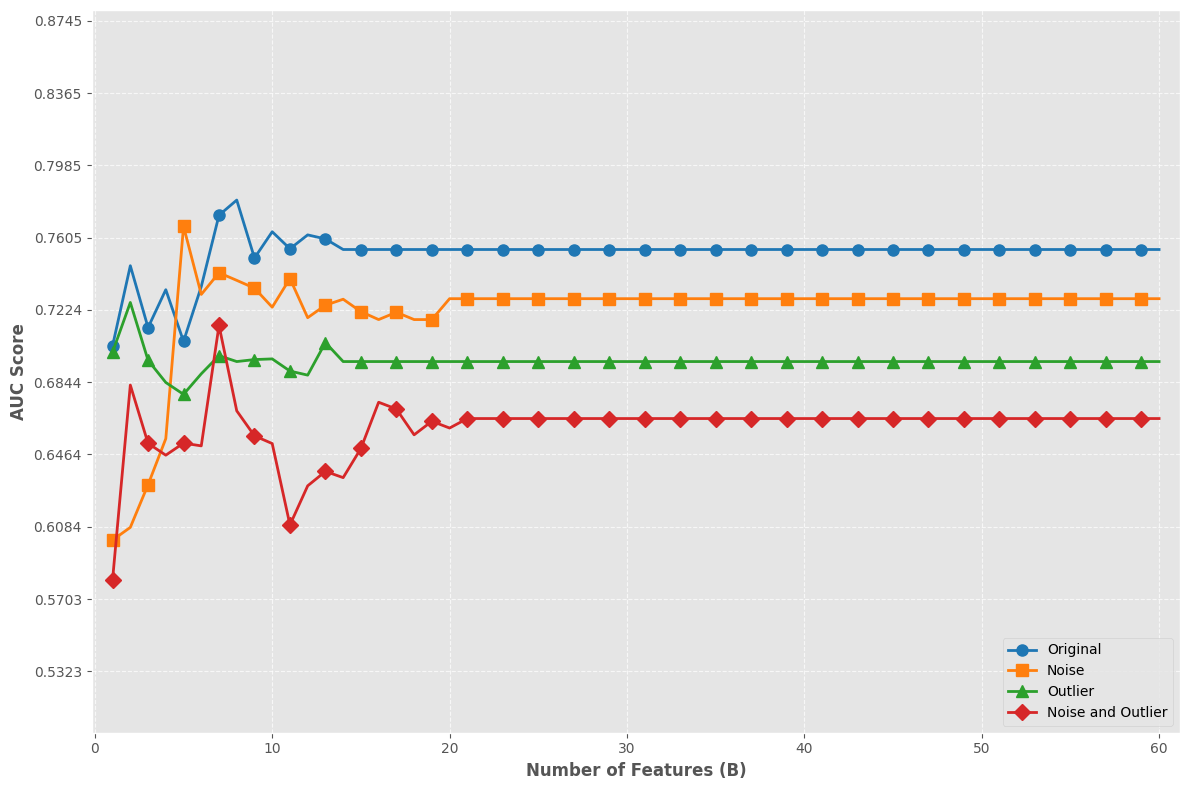

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from docplex.mp.model import Model
import warnings
warnings.filterwarnings("ignore")

def calculate_auc_for_features(file_name, C, tau):
    """Tính AUC cho mỗi giá trị B của một dataset"""
    # Đọc và chuẩn bị dữ liệu
    df = pd.read_csv(file_name, header= None)

    X = df.iloc[:, 0:60].values
    y = df .iloc[:,60].values
    # Chuyển đổi nhãn từ B/M thành -1/1
    y = np.where(y == 'M', 1, -1)

    
    n_features = X.shape[1]
    B_values = range(1, n_features + 1)
    auc_scores = []
    
    for B in B_values:
        kf = KFold(n_splits=10, shuffle=True, random_state=42)
        fold_aucs = []
        
        for train_index, val_index in kf.split(X):
            # Chia dữ liệu train/validation
            X_train, X_val = X[train_index], X[val_index]
            y_train, y_val = y[train_index], y[val_index]
            
            # Chuẩn hóa dữ liệu
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_val = scaler.transform(X_val)
            
            # Tạo và giải quyết mô hình
            opt_mod = Model(name='Pin-FS-SVM')
            m, n = X_train.shape
            
            # Định nghĩa các biến
            w = opt_mod.continuous_var_list(n, name='w')
            b = opt_mod.continuous_var(name='b')
            v = opt_mod.binary_var_list(n, name='v')
            xi = opt_mod.continuous_var_list(m, lb=0, name='xi')
            z = opt_mod.continuous_var_list(n, lb=0, name='z')
            
            # Hàm mục tiêu
            opt_mod.minimize(opt_mod.sum(z[j] for j in range(n)) + C * opt_mod.sum(xi[i] for i in range(m)))
            
            # Các ràng buộc
            l = [-2] * n
            u = [2] * n
            
            for i in range(m):
                opt_mod.add_constraint(
                    y_train[i] * (opt_mod.sum(w[j] * X_train[i, j] for j in range(n)) + b) >= 1 - xi[i]
                )
                opt_mod.add_constraint(
                    y_train[i] * (opt_mod.sum(w[j] * X_train[i, j] for j in range(n)) + b) <= 1 + xi[i] * (1/tau)
                )
            
            opt_mod.add_constraint(opt_mod.sum(v[j] for j in range(n)) <= B)
            
            for j in range(n):
                opt_mod.add_constraint(w[j] <= v[j] * u[j])
                opt_mod.add_constraint(w[j] >= l[j] * v[j])
                opt_mod.add_constraint(w[j] <= z[j])
                opt_mod.add_constraint(w[j] >= -z[j])
            
            # Giải quyết mô hình
            solution = opt_mod.solve()
            
            if solution:
                w_opt = np.array([solution.get_value(f'w_{j}') for j in range(n)])
                b_opt = solution.get_value('b')
                y_pred = np.sign(np.dot(X_val, w_opt) + b_opt)
                fold_aucs.append(roc_auc_score(y_val, y_pred))
        
        mean_auc = np.mean(fold_aucs)
        auc_scores.append(mean_auc)
        print(f"Completed B={B} for {file_name}, AUC={mean_auc:.4f}")
    
    return list(B_values), auc_scores

# Cấu hình đồ thị
plt.figure(figsize=(12, 8))
plt.style.use('ggplot')

# Danh sách files và tham số
file_names = [
    'sonar.txt',
    'sonar_noise_label_feature.txt',
    'sonar_outlier.txt',
    'sonar_both_noise_outlier.txt'
]
# Màu sắc và style cho từng dataset
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
markers = ['o', 's', '^', 'D']
labels = ['Original', 'Noise', 'Outlier', 'Noise and Outlier']

# Lưu trữ tất cả giá trị AUC để tính range
all_auc_values = []
tau_values = [0.5,0.5,0.1,0.1]
C_values = [0.25,2,0.125,4]

# Vẽ đồ thị cho từng dataset
for i, (file_name, C, tau) in enumerate(zip(file_names, C_values, tau_values)):
    B_values, auc_scores = calculate_auc_for_features(file_name, C, tau)
    all_auc_values.extend(auc_scores)
    plt.plot(B_values, auc_scores, 
             color=colors[i], 
             marker=markers[i], 
             label=labels[i],
             linewidth=2,
             markersize=8,
             markevery=2)

# Tính toán range phù hợp cho trục y
min_auc = min(all_auc_values)
max_auc = max(all_auc_values)
# Điều chỉnh range để tập trung vào khoảng có ý nghĩa
y_min = max(0.5, min_auc - 0.1)  # AUC thường không có ý nghĩa dưới 0.5
y_max = min(1.0, max_auc + 0.1)  # AUC không thể vượt quá 1.0

# Thiết lập giới hạn trục y
plt.ylim(y_min, y_max)

# Thêm các đường grid ngang để dễ theo dõi
plt.grid(True, linestyle='--', alpha=0.7)
# Tăng số lượng đường grid ngang
plt.gca().yaxis.set_major_locator(plt.MultipleLocator((y_max - y_min) / 10))

# Tùy chỉnh đồ thị
plt.xlabel('Number of Features (B)', fontsize=12, fontweight='bold')
plt.ylabel('AUC Score', fontsize=12, fontweight='bold')
# plt.title('Sonar', fontsize=14, fontweight='bold')
plt.legend(fontsize=10, loc='lower right')

# Thêm padding
plt.margins(x=0.02)

# Điều chỉnh layout
plt.tight_layout()

# Lưu đồ thị
plt.savefig('auc_vs_features_adjusted.png', dpi=300, bbox_inches='tight')
plt.show()